In [1]:
# TODO 
# Does adam + one_cycle work better than rect+adam+ranger+fit_flat_cos?
# Map old data columns to user data column names

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
import pandas as pd

In [8]:
images_path = '../data/resized_and_user_images'
labels_path = '../data/resized_and_user_labels.csv'

In [12]:
y = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [13]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(160,160), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [14]:
dls = dblock.dataloaders(images_path, bs=32)
dls.c = dls.train.after_item.c
dls.show_batch()

RuntimeError: stack expects each tensor to be equal size, but got [3, 320, 320] at entry 0 and [3, 640, 640] at entry 3

In [170]:
learn = cnn_learner(
    dls, 
    resnet18, 
    loss_func=MSELossFlat(), 
).to_fp16(clip=0.1)

In [171]:
learn.freeze_to(-1)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.02754228748381138)

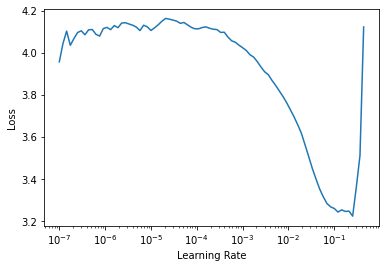

In [172]:
learn.lr_find()

In [173]:
learn.fit_one_cycle(
    5, 
    1e-2
)

epoch,train_loss,valid_loss,time
0,0.884860,0.248942,00:23
1,0.168413,0.038899,00:23
2,0.039449,0.019437,00:23
3,0.025757,0.013048,00:23
4,0.194287,0.012386,00:23


In [174]:
learn.save('top_layer')

In [175]:
learn = learn.load('top_layer')

In [176]:
learn.unfreeze()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=9.12010818865383e-07)

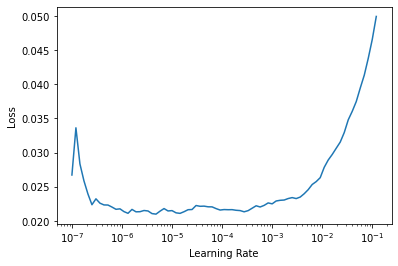

In [177]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.050565,0.011916,00:30
1,0.025213,0.010901,00:30
2,0.018985,0.009626,00:30
3,0.018868,0.009574,00:30
4,0.018154,0.008578,00:29
5,0.016011,0.008328,00:30
6,0.015353,0.007820,00:29
7,0.016601,0.008240,00:30
8,0.013926,0.006943,00:30
9,0.013890,0.006817,00:30


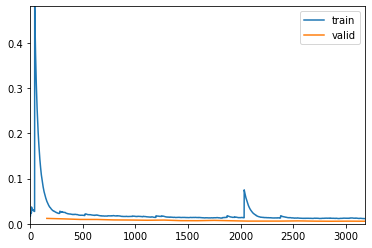

In [178]:
learn.fit_one_cycle(
    20, 
    1e-4, 
    cbs=[
        SaveModelCallback(), 
        ShowGraphCallback()
    ]
)

In [179]:
learn = learn.load('model')

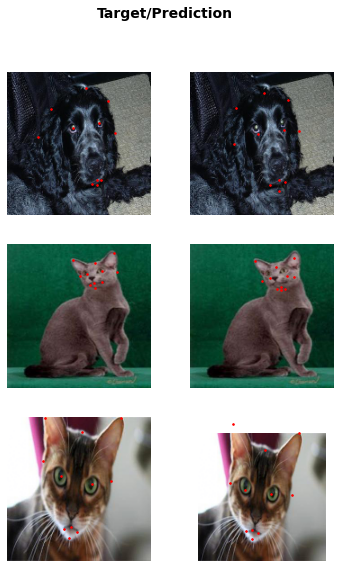

In [180]:
learn.show_results()

In [18]:
# learn.predict(pet_dataloaders.train_ds.items[0])

In [24]:
# learn.summary()

In [52]:
# learn.export('models/export.pkl')

In [16]:
# learn = load_learner('../models/export.pkl')